<a href="https://colab.research.google.com/github/leilaabdel/pexg-poag-pex-lipidomics/blob/main/statistical_analysis_poag_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/machine-learning-projects/lipidome+proteome-sig-metabolites/'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/machine-learning-projects/lipidome+proteome-sig-metabolites/"


## Imports

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt


In [4]:
ls data/

 combined_met_lipids_metaboanalyst.csv
'Copy of metabolomics.xlsx'
 lipidomics_anova.xlsx
 lipidomics.xlsx
 metabolomics.xlsx
 PXE_NEG_Truquant_Leila_Fold_Change.xlsx


# Load Data

The lipidomics data is called ` lipidomics.xlsx` and the metabolomics is called `metabolomics.xlsx`. We will use pandas to read this data in.


In [5]:
lipidomics_df = pd.read_excel('data/lipidomics.xlsx')

# Independent Lipidomics Analysis

In [6]:
lipidomics_df = lipidomics_df.drop(columns=['Sample_Number'])

In [7]:
lipidomics_df

,Disease,AEA(20:1),Cer(d16:1_14:0),Cer(d16:0_14:0),Cer(m18:1_14:0),Cer(d31:1),Cer(m32:0),Cer(m33:1),Cer(d18:1_14:0),Cer(m33:0),Cer(d18:0_14:0),Cer(m18:1_16:0),Cer(d17:1_16:0),Cer(m18:0_16:0),Cer(d33:0),Cer(d18:0_15:0),Cer(d18:2_16:0),Cer(d18:1_16:1),Cer(d34:2),Cer(d18:1_16:0),Cer(m18:1_16:0+O),Cer(d34:1),Cer(d18:0_16:0),Cer(t17:0_16:0),Cer(d35:2),Cer(m36:1),Cer(d35:1),Cer(m20:0_16:0),Cer(m19:0_17:0),Cer(m36:0),Cer(d19:0_16:0),Cer(d18:0_17:0),Cer(t18:0_16:0),Cer(d36:2),Cer(d18:2_18:0),Cer(d18:0_18:1),Cer(d18:1_18:0),Cer(m19:0_18:0),Cer(d18:0_18:0),Cer(d36:0),...,TG(15:0_15:0_20:4),TG(16:1_16:1_18:1),TG(16:0_16:1_18:1),TG(16:0_16:0_18:1),TG(18:0_16:0_16:0),TG(16:1_17:1_18:2),TG(16:1_17:1_18:1),TG(15:0_18:1_18:1),TG(16:0_17:0_18:1),TG(16:0_18:3_18:3),TG(16:0_18:2_18:3),TG(16:0_18:2_18:2),TG(16:0_18:1_18:2),TG(16:0_18:1_18:1),TG(18:0_16:0_18:1),TG(17:0_18:1_18:2),TG(17:0_18:1_18:1),TG(18:3_18:2_18:3),TG(18:3_18:2_18:2),TG(18:2_18:2_18:2),TG(16:0_18:1_20:5),TG(18:1_18:2_18:2),TG(18:1_18:1_18:2),TG(18:1_18:1_18:1),TG(18:0_18:1_18:1),TG(18:0_18:0_18:1),TG(18:0_18:0_18:0),TG(19:1_18:1_18:1),TG(20:5_18:2_18:2),TG(18:1_18:2_20:5),TG(18:1_18:2_20:4),TG(18:1_18:1_20:4),TG(18:1_18:2_20:2),TG(16:0_18:1_22:4),TG(20:1_18:1_18:2),TG(20:1_18:1_18:1),TG(20:0_18:1_18:1),TG(26:0_14:0_16:0),TG(16:1_18:1_24:0),TG(24:0_18:2_18:2)
0,Control,0.057,2.287,0.0,0.027,0.0,13.638,0.0,0.0,1.020,0.000,0.127,0.021,3.786,0.001,0.000,0.000,0.034,0.043,0.000,0.0,0.031,0.430,0,0.0,2.327,0.0,0.555,0.985,73.863,0.002,0.000,0.0,0.347,0.056,0.0,0.014,0.811,0.253,111.704,...,2.014,15.225,34.663,37.025,26.171,1.757,7.311,12.909,9.943,0.125,2.835,12.745,29.049,49.306,17.600,3.933,4.719,0.285,1.710,7.935,2.834,14.969,23.534,53.060,13.286,9.241,15.822,0.979,0.710,0.931,2.127,3.350,0.446,0.200,1.230,2.142,3.513,5.926,3.082,0.206
1,Control,0.000,4.859,0.0,0.011,0.0,27.158,0.0,0.0,1.669,0.000,0.028,0.005,7.699,0.010,0.000,0.031,0.126,0.116,0.011,0.0,0.000,0.506,0,0.0,5.200,0.0,1.657,2.070,163.159,0.000,0.000,0.0,0.663,0.000,0.0,0.000,0.914,0.038,180.761,...,4.126,26.479,62.859,64.126,53.333,2.909,9.935,24.251,19.132,0.299,5.413,25.435,58.828,90.245,29.643,6.718,8.133,0.831,4.326,18.707,4.628,29.426,46.742,100.321,22.546,12.237,37.828,1.916,1.707,1.863,3.544,6.008,1.317,0.244,2.062,4.013,6.039,10.316,5.298,0.526
2,Control,0.121,5.908,0.0,0.112,0.0,26.650,0.0,0.0,2.513,0.000,0.172,0.000,13.536,0.075,0.000,0.000,0.108,0.154,0.000,0.0,0.026,0.095,0,0.0,9.139,0.0,3.241,4.092,211.545,0.000,0.019,0.0,0.886,0.086,0.0,0.000,2.140,0.118,211.369,...,5.356,39.531,94.618,138.199,74.660,2.121,16.632,36.089,27.334,0.095,7.833,39.425,93.800,175.958,64.284,9.939,12.095,0.720,4.106,19.715,5.834,37.364,65.068,176.261,43.061,31.330,44.248,2.198,1.504,1.958,4.685,8.795,0.977,1.489,3.901,6.492,10.765,17.296,9.837,0.653
3,Control,0.000,1.624,0.0,0.002,0.0,12.051,0.0,0.0,0.492,0.000,0.021,0.000,2.717,0.001,0.000,0.010,0.052,0.031,0.000,0.0,0.012,0.035,t,0.0,2.015,0.0,0.393,0.711,69.685,0.000,0.000,0.0,0.174,0.015,0.0,0.006,0.566,0.068,60.165,...,1.352,9.772,22.426,25.548,16.151,1.160,4.533,9.153,6.763,0.181,2.472,15.204,32.768,42.966,15.705,2.457,3.026,0.244,1.432,8.811,1.974,15.895,26.893,59.557,12.989,7.830,11.951,0.704,0.794,0.876,1.805,3.234,0.690,0.588,0.432,1.959,2.521,3.848,2.463,0.176
4,Control,0.004,0.575,0.0,0.009,0.0,3.255,0.0,0.0,0.152,0.004,0.004,0.000,1.260,0.006,0.000,0.000,0.021,0.016,0.000,0.0,0.003,0.053,0,0.0,0.771,0.0,0.189,0.273,96.376,0.000,0.000,0.0,0.121,0.006,0.0,0.000,0.108,0.017,15.020,...,0.566,3.518,8.694,10.021,8.860,0.431,1.477,3.480,2.590,0.031,0.703,4.931,8.701,12.470,4.463,0.899,1.200,0.114,0.875,3.126,0.461,5.558,6.549,14.758,3.808,2.252,5.445,0.263,0.260,0.294,0.440,0.768,0.118,0.072,0.157,0.578,1.009,2.560,0.899,0.062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

POAG diagnosis
* Open angle as determined by gonioscopy
* Glaucomatous optic neuropathy- increased VCDR, asymmetry >0.2 and/or focal
notches of the neuroretinal border
* Compatible F defects

PEXG diagnosis
* Slit-lamp examination
* Open-angle glaucoma associated with exfoliative material in iris or lens

PEX diagnosis
* Slit-lamp examination
* Exfoliative material in iris or lens
* No signs of glaucomatous optic neuropathy
* No compatible V defect

(credits: Jada Moris)


In [8]:
np.unique(lipidomics_df['Disease'])

array(['Control', 'PEX', 'PEXG', 'POAG'], dtype=object)

In [9]:
lipid_encoder = LabelEncoder()
Y = np.asarray([lipid_encoder.fit_transform(np.asarray(lipidomics_df , dtype='str')[: , 0])]).T.ravel()

In [10]:
lipidomics_df = lipidomics_df.drop(columns=['Disease'])

# Comparing PEX to Control

In [19]:
lipidomics_df_pex_v_c = pd.read_excel('data/lipidomics.xlsx', sheet_name=1)
lipidomics_df_pex_v_c.describe()

,AEA(20:1),Cer(d16:1_14:0),Cer(d16:0_14:0),Cer(m18:1_14:0),Cer(d31:1),Cer(m32:0),Cer(m33:1),Cer(d18:1_14:0),Cer(m33:0),Cer(d18:0_14:0),Cer(m18:1_16:0),Cer(d17:1_16:0),Cer(m18:0_16:0),Cer(d33:0),Cer(d18:0_15:0),Cer(d18:2_16:0),Cer(d18:1_16:1),Cer(d34:2),Cer(d18:1_16:0),Cer(m18:1_16:0+O),Cer(d34:1),Cer(d18:0_16:0),Cer(d35:2),Cer(m36:1),Cer(d35:1),Cer(m20:0_16:0),Cer(m19:0_17:0),Cer(m36:0),Cer(d19:0_16:0),Cer(d18:0_17:0),Cer(t18:0_16:0),Cer(d36:2),Cer(d18:2_18:0),Cer(d18:0_18:1),Cer(d18:1_18:0),Cer(m19:0_18:0),Cer(d18:0_18:0),Cer(d36:0),Cer(m18:1_20:0),Cer(t36:0),...,TG(15:0_15:0_20:4),TG(16:1_16:1_18:1),TG(16:0_16:1_18:1),TG(16:0_16:0_18:1),TG(18:0_16:0_16:0),TG(16:1_17:1_18:2),TG(16:1_17:1_18:1),TG(15:0_18:1_18:1),TG(16:0_17:0_18:1),TG(16:0_18:3_18:3),TG(16:0_18:2_18:3),TG(16:0_18:2_18:2),TG(16:0_18:1_18:2),TG(16:0_18:1_18:1),TG(18:0_16:0_18:1),TG(17:0_18:1_18:2),TG(17:0_18:1_18:1),TG(18:3_18:2_18:3),TG(18:3_18:2_18:2),TG(18:2_18:2_18:2),TG(16:0_18:1_20:5),TG(18:1_18:2_18:2),TG(18:1_18:1_18:2),TG(18:1_18:1_18:1),TG(18:0_18:1_18:1),TG(18:0_18:0_18:1),TG(18:0_18:0_18:0),TG(19:1_18:1_18:1),TG(20:5_18:2_18:2),TG(18:1_18:2_20:5),TG(18:1_18:2_20:4),TG(18:1_18:1_20:4),TG(18:1_18:2_20:2),TG(16:0_18:1_22:4),TG(20:1_18:1_18:2),TG(20:1_18:1_18:1),TG(20:0_18:1_18:1),TG(26:0_14:0_16:0),TG(16:1_18:1_24:0),TG(24:0_18:2_18:2)
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.013656,1.838906,0.066937,1.481750,0.069125,7.243875,0.259062,4.080063,0.531281,5.043719,6.798844,0.664563,3.234469,0.004906,0.550312,3.967844,0.102906,0.189656,11.558750,8.296688,0.304687,39.405594,0.041219,2.125500,0.112375,0.801031,0.971688,91.608125,0.146156,0.249906,8.270344,0.517938,0.368219,0.106156,0.234594,0.671094,0.660281,58.823687,0.062344,0.209719,...,2.664781,21.677844,41.610125,42.686469,32.853719,2.539656,10.545344,19.936625,13.660406,0.160437,2.936438,18.690969,41.717937,61.799125,20.030344,6.119063,7.488844,0.252250,1.851563,9.338969,3.272531,19.26775,32.556625,69.162969,17.440313,9.998969,18.281625,1.701094,1.237187,1.569188,2.882125,4.581375,0.618156,0.770125,1.981594,3.400906,4.714781,6.184750,4.094594,0.402500
std,0.025183,1.424704,0.378656,8.218961,0.378517,6.858009,1.465479,23.080319,0.510410,28.524101,38.211199,3.647927,2.952734,0.013608,3.113038,22.415771,0.315189,0.400321,65.064614,46.824513,1.579874,222.238755,0.232622,1.953112,0.595478,0.909851,0.949575,86.974298,0.816236,1.363276,46.692427,0.836037,1.985255,0.596146,1.256509,0.573152,3.195565,56.670981,0.232507,0.351296,...,5.172842,50.571172,71.050673,61.704432,49.568303,7.415606,28.590548,48.752654,27.890789,0.340420,5.159008,25.601161,59.009038,80.806267,26.665598,15.948478,19.145657,0.298383,1.790808,10.425343,5.238739,25.88306,42.360916,82.890629,22.585941,13.097635,24.007176,4.406137,1.798643,2.669923,4.569902,6.113416,0.883745,2.327521,4.350836,5.474413,7.647571,8.548949,6.752862,0.772304
min,0.000000,0.461000,0.000000,0.002000,0.000000,0.067000,0.000000,0.000000,0.102000,0.000000,0.003000,0.000000,0.763000,0.000000,0.000000,0.000000,0.004000,0.004000,0.000000,0.000000,0.000000,0.017000,0.000000,0.473000,0.000000,0.105000,0.133000,13.838000,0.000000,0.000000,0.000000,0.055000,0.000000,0.000000,0.000000,0.108000,0.003000,7.898000,0.00000

In [20]:
lipid_encoder = LabelEncoder()
Y = np.asarray([lipid_encoder.fit_transform(np.asarray(lipidomics_df_pex_v_c , dtype='str')[: , 1])]).T.ravel()

In [22]:
np.unique(lipidomics_df_pex_v_c['Disease'])

array(['Control', 'PEX'], dtype=object)

In [23]:
lipidomics_df_pex_v_c = lipidomics_df_pex_v_c.drop(columns=['Disease' , 'Sample_Number'])

In [24]:
X = lipidomics_df_pex_v_c.to_numpy()
#bug in the sheet
X[3][22] = 0
X = np.asarray(X , dtype='float32')
small_seed = 1e-5
#X = np.log(X + small_seed)

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
seed = 42
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression(random_state=0, max_iter=10000 , solver='sag')
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print("MEAN CV SCORE: " , results.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MEAN CV SCORE:  0.8666666666666666


## Confusion Matrix For Predictions

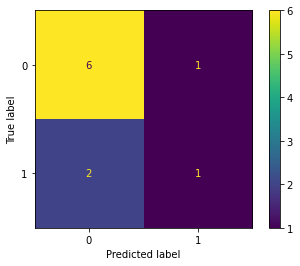

In [28]:
from sklearn.metrics import plot_confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(
        (X - np.min(X)), Y, random_state=1, test_size=0.3)
clf = LogisticRegression(random_state=1 , max_iter=10000 , solver='sag')
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

# Comparing PEXG to Control

In [32]:
lipidomics_df_pexg_v_c = pd.read_excel('data/lipidomics.xlsx', sheet_name=3)
lipidomics_df_pexg_v_c.describe()

,AEA(20:1),Cer(d16:1_14:0),Cer(d16:0_14:0),Cer(m18:1_14:0),Cer(d31:1),Cer(m32:0),Cer(m33:1),Cer(d18:1_14:0),Cer(m33:0),Cer(d18:0_14:0),Cer(m18:1_16:0),Cer(d17:1_16:0),Cer(m18:0_16:0),Cer(d33:0),Cer(d18:0_15:0),Cer(d18:2_16:0),Cer(d18:1_16:1),Cer(d34:2),Cer(d18:1_16:0),Cer(m18:1_16:0+O),Cer(d34:1),Cer(d18:0_16:0),Cer(d35:2),Cer(m36:1),Cer(d35:1),Cer(m20:0_16:0),Cer(m19:0_17:0),Cer(m36:0),Cer(d19:0_16:0),Cer(d18:0_17:0),Cer(t18:0_16:0),Cer(d36:2),Cer(d18:2_18:0),Cer(d18:0_18:1),Cer(d18:1_18:0),Cer(m19:0_18:0),Cer(d18:0_18:0),Cer(d36:0),Cer(m18:1_20:0),Cer(t36:0),...,TG(15:0_15:0_20:4),TG(16:1_16:1_18:1),TG(16:0_16:1_18:1),TG(16:0_16:0_18:1),TG(18:0_16:0_16:0),TG(16:1_17:1_18:2),TG(16:1_17:1_18:1),TG(15:0_18:1_18:1),TG(16:0_17:0_18:1),TG(16:0_18:3_18:3),TG(16:0_18:2_18:3),TG(16:0_18:2_18:2),TG(16:0_18:1_18:2),TG(16:0_18:1_18:1),TG(18:0_16:0_18:1),TG(17:0_18:1_18:2),TG(17:0_18:1_18:1),TG(18:3_18:2_18:3),TG(18:3_18:2_18:2),TG(18:2_18:2_18:2),TG(16:0_18:1_20:5),TG(18:1_18:2_18:2),TG(18:1_18:1_18:2),TG(18:1_18:1_18:1),TG(18:0_18:1_18:1),TG(18:0_18:0_18:1),TG(18:0_18:0_18:0),TG(19:1_18:1_18:1),TG(20:5_18:2_18:2),TG(18:1_18:2_20:5),TG(18:1_18:2_20:4),TG(18:1_18:1_20:4),TG(18:1_18:2_20:2),TG(16:0_18:1_22:4),TG(20:1_18:1_18:2),TG(20:1_18:1_18:1),TG(20:0_18:1_18:1),TG(26:0_14:0_16:0),TG(16:1_18:1_24:0),TG(24:0_18:2_18:2)
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.00000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.402081,1.895351,0.057892,1.287757,0.062189,8.408108,0.224054,3.532027,0.592243,4.363622,5.963054,0.590784,3.805649,0.178568,0.476270,3.433622,0.129054,0.169324,10.012432,7.175514,0.276676,34.159351,0.035865,2.501676,0.103243,0.854514,1.057054,102.753649,0.126784,0.218757,7.152730,1.289946,0.335541,0.091811,0.217730,0.808351,0.589730,72.426432,0.062108,0.236486,...,3.772784,28.925865,55.766459,55.081703,42.284486,3.556514,14.118811,25.973703,17.257622,0.315162,4.262865,25.642297,55.335514,85.642622,24.717541,7.931270,9.291378,0.434622,3.190757,13.153216,4.508757,25.589784,43.211000,101.406000,24.012189,12.100595,24.442784,2.136784,2.043892,2.310757,3.967216,7.104595,0.79800,0.798973,2.674135,4.435541,5.811784,7.714162,5.312973,0.496811
std,2.352010,1.433973,0.352143,7.643096,0.351762,8.742962,1.362868,21.463708,0.658469,26.526655,35.524631,3.391097,4.028650,0.689835,2.895012,20.846032,0.315973,0.353962,60.507537,43.546351,1.468924,206.667477,0.216303,2.713680,0.554104,1.105716,1.091601,112.669363,0.759065,1.267635,43.423445,4.681211,1.844296,0.554422,1.168571,0.763140,2.971285,64.590593,0.216965,0.363762,...,6.093166,52.884397,81.250521,72.571964,58.286651,7.824706,29.597245,49.540963,28.844351,0.561375,6.514249,34.099802,70.890470,111.978878,32.289363,16.095596,18.883734,0.843974,6.037305,19.063799,6.281117,33.843577,54.962502,144.240751,32.032975,15.132481,33.823316,4.379239,3.778718,3.685654,5.777533,10.938345,1.10798,2.213725,4.541553,6.217904,8.389174,10.292045,7.774631,0.821452
min,0.000000,0.461000,0.000000,0.000000,0.000000,1.448000,0.000000,0.000000,0.076000,0.000000,0.003000,0.000000,0.973000,0.000000,0.000000,0.000000,0.004000,0.004000,0.000000,0.000000,0.000000,0.017000,0.000000,0.549000,0.000000,0.071000,0.133000,13.838000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108000,0.000000,7.89800

In [33]:
lipid_encoder = LabelEncoder()
Y = np.asarray([lipid_encoder.fit_transform(np.asarray(lipidomics_df_pexg_v_c , dtype='str')[: , 1])]).T.ravel()

In [34]:
np.unique(lipidomics_df_pexg_v_c['Disease'])

array(['Control', 'PEXG'], dtype=object)

In [35]:
lipidomics_df_pexg_v_c = lipidomics_df_pexg_v_c.drop(columns=['Disease' , 'Sample_Number'])

In [36]:
X = lipidomics_df_pexg_v_c.to_numpy()
#bug in the sheet
X[3][22] = 0
X = np.asarray(X , dtype='float32')
small_seed = 1e-5
#X = np.log(X + small_seed)

## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression(random_state=0, max_iter=10000 , solver='sag')
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print("MEAN CV SCORE: " , results.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MEAN CV SCORE:  0.8666666666666666


## Confusion Matrix For Predictions

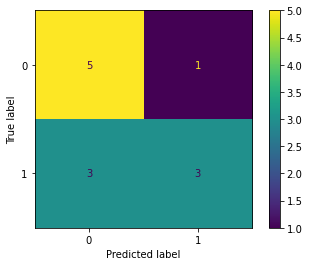

In [38]:
from sklearn.metrics import plot_confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(
        (X - np.min(X)), Y, random_state=1, test_size=0.3)
clf = LogisticRegression(random_state=1 , max_iter=10000 , solver='sag')
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

# Comparing POAG to Control

In [39]:
lipidomics_df_poag_v_c = pd.read_excel('data/lipidomics.xlsx', sheet_name=2)
lipidomics_df_poag_v_c.describe()

,AEA(20:1),Cer(d16:1_14:0),Cer(d16:0_14:0),Cer(m18:1_14:0),Cer(d31:1),Cer(m32:0),Cer(m33:1),Cer(d18:1_14:0),Cer(m33:0),Cer(d18:0_14:0),Cer(m18:1_16:0),Cer(d17:1_16:0),Cer(m18:0_16:0),Cer(d33:0),Cer(d18:0_15:0),Cer(d18:2_16:0),Cer(d18:1_16:1),Cer(d34:2),Cer(d18:1_16:0),Cer(m18:1_16:0+O),Cer(d34:1),Cer(d18:0_16:0),Cer(d35:2),Cer(m36:1),Cer(d35:1),Cer(m20:0_16:0),Cer(m19:0_17:0),Cer(m36:0),Cer(d19:0_16:0),Cer(d18:0_17:0),Cer(t18:0_16:0),Cer(d36:2),Cer(d18:2_18:0),Cer(d18:0_18:1),Cer(d18:1_18:0),Cer(m19:0_18:0),Cer(d18:0_18:0),Cer(d36:0),Cer(m18:1_20:0),Cer(t36:0),...,TG(15:0_15:0_20:4),TG(16:1_16:1_18:1),TG(16:0_16:1_18:1),TG(16:0_16:0_18:1),TG(18:0_16:0_16:0),TG(16:1_17:1_18:2),TG(16:1_17:1_18:1),TG(15:0_18:1_18:1),TG(16:0_17:0_18:1),TG(16:0_18:3_18:3),TG(16:0_18:2_18:3),TG(16:0_18:2_18:2),TG(16:0_18:1_18:2),TG(16:0_18:1_18:1),TG(18:0_16:0_18:1),TG(17:0_18:1_18:2),TG(17:0_18:1_18:1),TG(18:3_18:2_18:3),TG(18:3_18:2_18:2),TG(18:2_18:2_18:2),TG(16:0_18:1_20:5),TG(18:1_18:2_18:2),TG(18:1_18:1_18:2),TG(18:1_18:1_18:1),TG(18:0_18:1_18:1),TG(18:0_18:0_18:1),TG(18:0_18:0_18:0),TG(19:1_18:1_18:1),TG(20:5_18:2_18:2),TG(18:1_18:2_20:5),TG(18:1_18:2_20:4),TG(18:1_18:1_20:4),TG(18:1_18:2_20:2),TG(16:0_18:1_22:4),TG(20:1_18:1_18:2),TG(20:1_18:1_18:1),TG(20:0_18:1_18:1),TG(26:0_14:0_16:0),TG(16:1_18:1_24:0),TG(24:0_18:2_18:2)
count,42.000000,42.00000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.00000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.013048,1.93750,0.051000,1.141048,0.053571,7.003571,0.197381,3.111262,0.499595,3.852405,5.211476,0.513905,3.323500,0.004500,0.419786,3.026762,0.124119,0.145095,8.882976,6.364048,0.243667,30.199238,0.031667,2.127571,0.089119,0.807119,0.996857,92.361857,0.111714,0.193429,6.341905,0.413667,0.292548,0.081619,0.186119,0.575500,0.529976,60.605762,0.050262,0.265833,...,3.255262,22.262714,43.908286,44.929524,33.478143,2.619190,10.767262,20.728238,14.214214,0.334833,4.500857,23.410143,44.903619,65.224500,20.088524,6.396881,7.545452,0.637143,5.109333,16.784571,3.80381,24.966810,35.803333,69.708024,18.019976,10.217238,18.643500,1.764762,2.439143,2.245738,3.392571,5.012476,0.839524,0.769286,2.311976,3.410452,4.624190,6.279119,3.866000,0.391143
std,0.023480,1.70512,0.330518,7.173312,0.330372,8.274794,1.279175,20.145744,0.510451,24.896481,33.350592,3.183918,3.094689,0.014136,2.717204,19.565718,0.329821,0.323352,56.785015,40.866673,1.378716,193.964646,0.203016,2.051815,0.519889,0.743010,0.932125,87.880384,0.712485,1.189929,40.751510,0.627140,1.731896,0.520289,1.096744,0.510487,2.789312,59.378054,0.203399,0.534880,...,5.502249,44.730841,64.386274,57.166561,45.766603,6.535852,25.128709,43.095944,24.958391,0.657204,7.029449,28.492084,55.163774,77.791952,24.702034,14.104635,16.894062,1.367383,11.137699,29.588668,5.06116,32.366577,39.968500,80.920064,21.453174,12.798379,22.945934,3.932935,4.482209,3.299624,4.458271,6.246019,1.298546,2.100246,3.953345,4.906513,6.893763,8.099158,6.046461,0.685428
min,0.000000,0.46100,0.000000,0.002000,0.000000,0.653000,0.000000,0.000000,0.075000,0.000000,0.002000,0.000000,0.973000,0.000000,0.000000,0.000000,0.003000,0.004000,0.000000,0.000000,0.000000,0.017000,0.000000,0.609000,0.000000,0.105000,0.133000,13.838000,0.000000,0.000000,0.000000,0.055000,0.000000,0.000000,0.000000,0.108000,0.000000,7.898000,0.000000,

In [40]:
lipid_encoder = LabelEncoder()
Y = np.asarray([lipid_encoder.fit_transform(np.asarray(lipidomics_df_poag_v_c , dtype='str')[: , 1])]).T.ravel()

In [41]:
np.unique(lipidomics_df_poag_v_c['Disease'])

array(['Control', 'POAG'], dtype=object)

In [42]:
lipidomics_df_poag_v_c = lipidomics_df_poag_v_c.drop(columns=['Disease' , 'Sample_Number'])

In [43]:
X = lipidomics_df_poag_v_c.to_numpy()
#bug in the sheet
X[3][22] = 0
X = np.asarray(X , dtype='float32')
small_seed = 1e-5
#X = np.log(X + small_seed)

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression(random_state=0, max_iter=10000 , solver='sag')
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print("MEAN CV SCORE: " , results.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MEAN CV SCORE:  0.71


## Confusion Matrix For Predictions

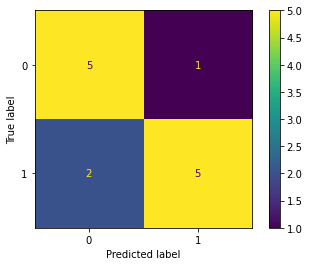

In [45]:
from sklearn.metrics import plot_confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(
        (X - np.min(X)), Y, random_state=1, test_size=0.3)
clf = LogisticRegression(random_state=1 , max_iter=10000 , solver='sag')
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()